**Jake McRoberts  
July 9th, 2017  
Case Study: Retail Sales Data**

# Improve Demand Forecasting using Retail Sales Data

Python version used for analyses: 3.6.X

Data files: 
- sales.txt
- article_master.txt

Tasks:
1. Prepare and analyze the data to assure sufficient quality and suitability for the business case study.
2. Identify what is driving sales and which type of promotion has a stronger impact on sales.
3. Forecast sales (sold units) for the following month. 
4. Perform appropriate diagnostics to check whether your methods and results from above are reliable.
5. Conclusions and what I would have improved on

## 1. Import, clean, and wrangle sales data to ensure data quality and suitability for analysis

### Import Data

In [81]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import machine learning packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [3]:
# import transactional sales data of articles into a pandas dataframe
data_sales = pd.read_csv("sales.txt", sep = ";", parse_dates=['retailweek'])

# import attribute data of sold articles
data_attribute = pd.read_csv("article_master.txt", sep = ";")

### Inspect Data

Verify data looks clean and suitable from a high level view of it.

In [4]:
data_sales.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0


In [5]:
data_sales.shape

(81426, 9)

Check for any NaN values in sales transactional data. False means there are no NaN's in the dataset.

In [6]:
data_sales.isnull().values.any()

False

In [7]:
data_sales.describe()

,sales,regular_price,current_price,ratio,promo1,promo2
count,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000
mean,57.048375,52.620695,28.356811,0.544464,0.065041,0.005060
std,88.506045,35.549601,22.704746,0.192692,0.246599,0.070953
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000
50%,26.000000,41.450000,20.950000,0.523526,0.000000,0.000000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000


In [8]:
data_attribute.head()

,article,category,productgroup,cost
0,OC6355,TRAINING,SHOES,13.29
1,AP5568,TRAINING,SHORTS,2.29
2,CB8861,GOLF,HARDWARE ACCESSORIES,1.70
3,LI3529,RUNNING,SHOES,9.00
4,GG8661,RELAX CASUAL,SHOES,9.60


In [9]:
data_attribute.shape

(476, 4)

Check for any NaN values in sales attribute data. False means there are no NaN's in the dataset.

In [10]:
data_attribute.isnull().values.any()

False

In [11]:
data_attribute.describe()

,cost
count,476.00000
mean,5.17792
std,3.36282
min,0.40000
25%,2.60000
50%,4.25000
75%,7.90000
max,19.80000


From a high level perspective, the data looks okay. There aren't any NaN's in either dataset and the size of the dataframes makes sense based on the size of the raw data in the text files. The descriptive statistics on the data looks great as well.

Use pandas `merge` function to combine the transactional sales data with the sales attribute data like a SQL join. Use an inner join since I want to add cost data (if there is any) for the given transactional data. If there isn't any cost data, then I will not use the transactional sales data. I'll try a left join first to see if there are any cases where there is transactional data but not cost data for a given article. If there aren't many cases like this, then I will go ahead with the inner join.

In [12]:
data_leftJoined = pd.merge(data_sales, data_attribute, how = 'left', on = 'article')
data_leftJoined.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,RUNNING,T-SHIRTS,3.2
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,RUNNING,T-SHIRTS,3.2
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,RUNNING,T-SHIRTS,3.2
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,RUNNING,T-SHIRTS,3.2
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,RUNNING,T-SHIRTS,3.2


In [13]:
data_leftJoined.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,cost
count,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81303.000000
mean,57.048375,52.620695,28.356811,0.544464,0.065041,0.005060,5.002254
std,88.506045,35.549601,22.704746,0.192692,0.246599,0.070953,3.352216
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,0.400000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,2.400000
50%,26.000000,41.450000,20.950000,0.523526,0.000000,0.000000,4.000000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000,7.700000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000,19.800000


Investigate why there are less cost data points (count) than the other columns of data - likely due to there not being cost data for an article that had transactional sales data.

In [14]:
data_leftJoined[data_leftJoined.isnull().values].shape

(369, 12)

As expected, there are 369 NaN's for missing cost data for an article that had cost data. I can fix this by replacing the NaN's with 0's as I show below.

In [15]:
data_leftJoined.fillna(0, inplace = True)
data_leftJoined[data_leftJoined.isnull().values]

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost


In [16]:
data_leftJoined.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,cost
count,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000
mean,57.048375,52.620695,28.356811,0.544464,0.065041,0.005060,4.994698
std,88.506045,35.549601,22.704746,0.192692,0.246599,0.070953,3.355312
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,0.000000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,2.400000
50%,26.000000,41.450000,20.950000,0.523526,0.000000,0.000000,3.950000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000,7.700000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000,19.800000


Even though I can fix the NaN values in the left join, I am going to go forward with the inner join so for all of the data I have both transactional sales and cost data. I want to avoid filling in NaN's with artificial 0's (or some other arbitrary value). Perform inner join of sales and attribute data.

In [17]:
data_joined = pd.merge(data_sales, data_attribute, how = 'inner', on = 'article')
data_joined.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,RUNNING,T-SHIRTS,3.2
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,RUNNING,T-SHIRTS,3.2
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,RUNNING,T-SHIRTS,3.2
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,RUNNING,T-SHIRTS,3.2
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,RUNNING,T-SHIRTS,3.2


In [18]:
data_joined.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,cost
count,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000
mean,57.107868,52.661044,28.377229,0.544421,0.065041,0.005067,5.002254
std,88.552281,35.561332,22.714819,0.192656,0.246599,0.071006,3.352216
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,0.400000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,2.400000
50%,26.000000,41.950000,21.950000,0.523526,0.000000,0.000000,4.000000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000,7.700000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000,19.800000


Verify there are no NaN values. False means there are no NaN's in the dataset.

In [19]:
data_joined.isnull().values.any()

False

There are no NaN values. Joined data looks good to move on to exploratory data analysis through plotting. It will be very useful to visualize the different categories of sales data.

### Plot Data

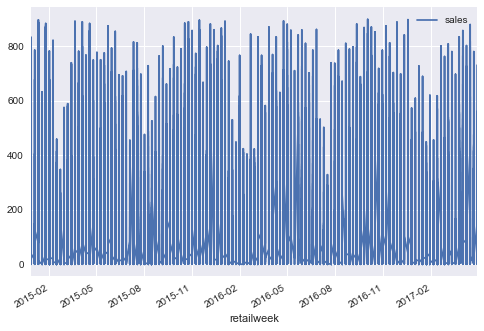

In [20]:
plt.figure()
data_joined.plot(x = 'retailweek', y = 'sales')
plt.show()

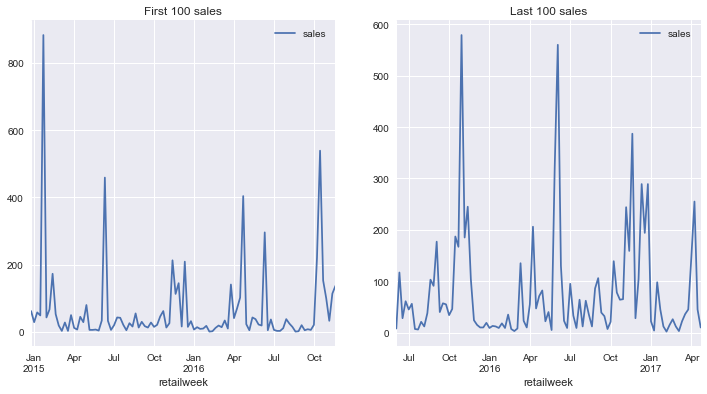

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined[0:100].plot(ax=axes[0], x = 'retailweek', y = 'sales')
axes[0].set_title('First 100 sales')
data_joined[-100:-1].plot(ax=axes[1], x = 'retailweek', y = 'sales')
axes[1].set_title('Last 100 sales')
plt.show()

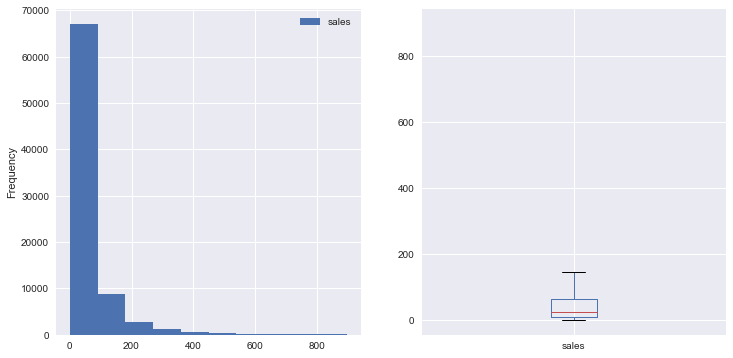

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], y = 'sales', kind = 'hist')
data_joined.plot(ax = axes[1], y = 'sales', kind = 'box')
plt.show()

Sales data looks as expected; there are a lot of outliers likely at high sale times (like Christmas / winter holiday and summer before school starts). The sales data is pretty cyclical in addition to being heavily skewed with the vast majority of weeks with sales of less than 100 items for each item type.

Examine price data now.

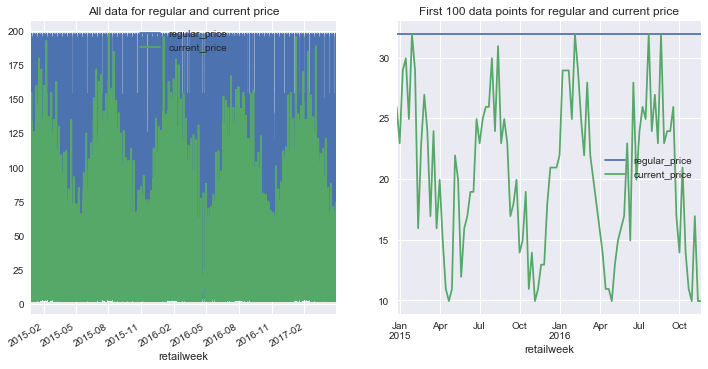

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], x = 'retailweek', y = ['regular_price', 'current_price'])
axes[0].set_title('All data for regular and current price')
data_joined[0:100].plot(ax = axes[1], x = 'retailweek', y = ['regular_price', 'current_price'])
axes[1].set_title('First 100 data points for regular and current price')
plt.show()

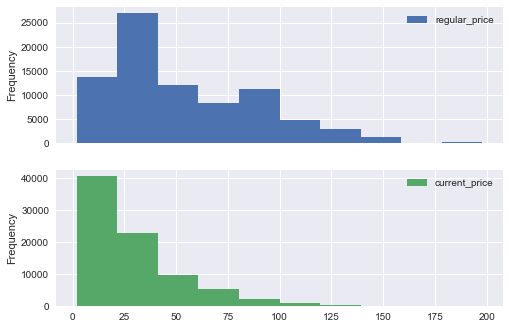

In [24]:
plt.figure()
data_joined.plot(y = ['regular_price', 'current_price'], kind = 'hist', subplots = True)
plt.show()

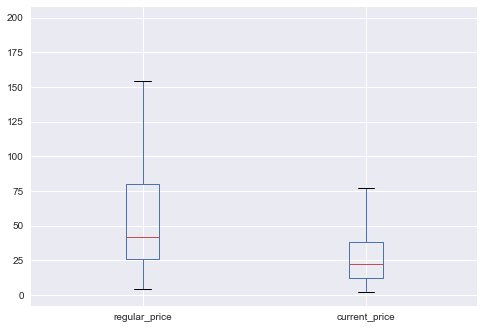

In [25]:
plt.figure()
data_joined.plot(y = ['regular_price', 'current_price'], kind = 'box')
plt.show()

Pricing data (regular price and current price) both look as expected; the regular price is higher than the current price (indicating that discounts, like promo1 and/or promo2, reduce the price). Both price datasets are skewed but the regular price looks like it could be closer to a normal distribution. The majority of items that are sold are priced under 75 euro.

Look into the ratio data (`ratio = current_price / regular_price`).

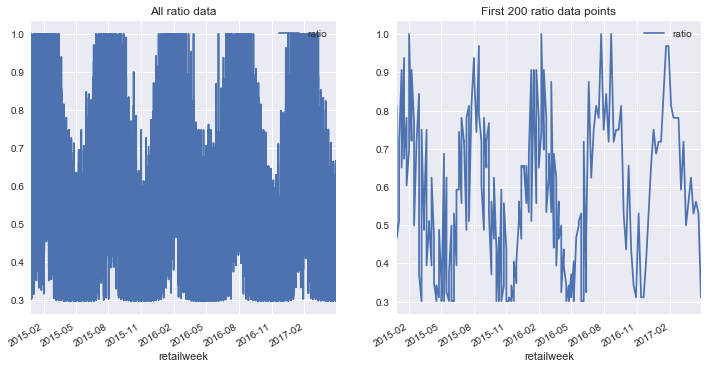

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], x = 'retailweek', y = 'ratio')
axes[0].set_title('All ratio data')
data_joined[0:200].plot(ax = axes[1], x = 'retailweek', y = 'ratio')
axes[1].set_title('First 200 ratio data points')
plt.show()

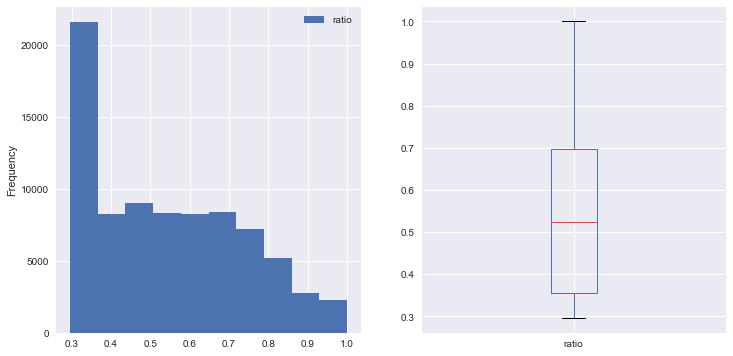

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], y = 'ratio', kind = 'hist')
data_joined.plot(ax = axes[1], y = 'ratio', kind = 'box')
plt.show()

Ratio data is similarly skewed like the sales and pricing data - the cyclical nature of pricing items is very apparent in the data when zooming in on a smaller sample of the ratio data.

Examine the promo data (1 and 2) next.

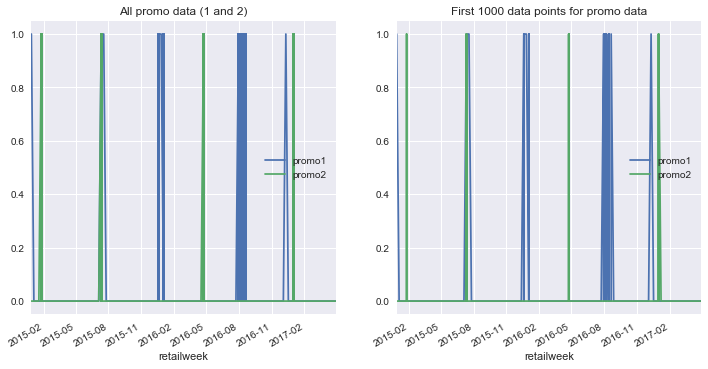

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], x = 'retailweek', y = ['promo1', 'promo2'])
axes[0].set_title('All promo data (1 and 2)')
data_joined[0:1000].plot(ax = axes[1], x = 'retailweek', y = ['promo1', 'promo2'])
axes[1].set_title('First 1000 data points for promo data')
plt.show()

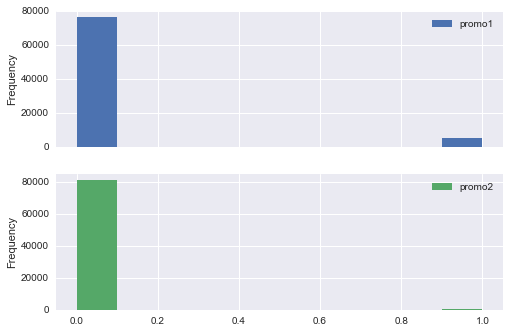

In [29]:
plt.figure()
data_joined.plot(y = ['promo1', 'promo2'], kind = 'hist', subplots = True)
plt.show()

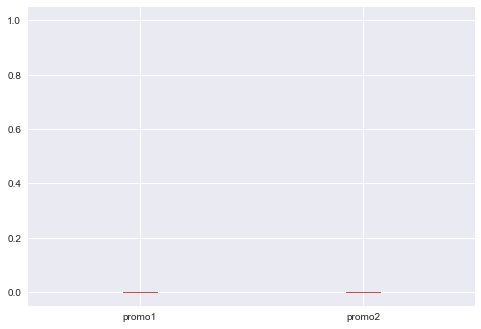

In [30]:
plt.figure()
data_joined.plot(y = ['promo1', 'promo2'], kind = 'box')
plt.show()

Plotting the promotion data doesn't yield much when looking for a distribution since the values are either '0' or '1' at all times. It is good to confirm that the data is clean.

Inspect the actual cost data from the second text data file holding attribute data for each article of clothing.

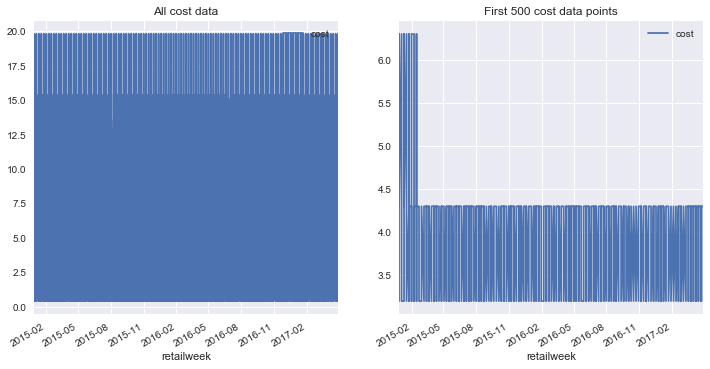

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], x = 'retailweek', y = 'cost')
axes[0].set_title('All cost data')
data_joined[0:500].plot(ax = axes[1], x = 'retailweek', y = 'cost')
axes[1].set_title('First 500 cost data points')
plt.show()

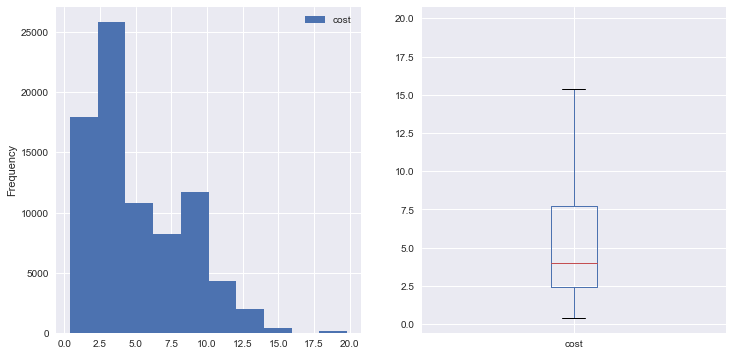

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], y = 'cost', kind = 'hist')
data_joined.plot(ax = axes[1], y = 'cost', kind = 'box')
plt.show()

Cost data looks reasonable; there aren't any large outliers. There is one item that costs roughly 20 euro. The data is skewed similarly to the other numerical data, although the shape is closest to the price data. I'll examine the potential outlier to see if it seems like a real data point.

In [33]:
data_joined[data_joined['cost'] > 17].shape

(123, 12)

The data point above is a real data point. There are 123 transactional sales data points for the Porsche shoes. I know that adidas has a relationship with Porsche for branding of clothing and it would make sense for it to be more expensive that a non-Porsche branded piece of clothing considering the Porsche brand.

Overall, the data looks great. I'll move on to digging into the data to find what drives sales and if the promotions provide value add to sales numbers while keeping profits high.

## 2. Identify what is driving sales and which type of promotion has a stronger impact on sales.

### Transactional Sales Data Correlation Matrix

Create a correlation matrix to see how each of the promotions and ratio play into the number of sales.

In [34]:
# calculate correlation matrix
corr_sales = data_joined.corr()
corr_sales

,sales,regular_price,current_price,ratio,promo1,promo2,cost
sales,1.000000,1.839857e-02,-0.102018,-0.257473,1.032704e-01,0.010210,2.733576e-02
regular_price,0.018399,1.000000e+00,0.842917,-0.042704,2.757147e-18,0.010322,9.430526e-01
current_price,-0.102018,8.429173e-01,1.000000,0.408878,6.875311e-02,0.022557,7.916877e-01
ratio,-0.257473,-4.270398e-02,0.408878,1.000000,1.518774e-01,0.028358,-4.497662e-02
promo1,0.103270,2.757147e-18,0.068753,0.151877,1.000000e+00,0.053529,-2.981691e-18
promo2,0.010210,1.032208e-02,0.022557,0.028358,5.352861e-02,1.000000,-1.102974e-02
cost,0.027336,9.430526e-01,0.791688,-0.044977,-2.981691e-18,-0.011030,1.000000e+00


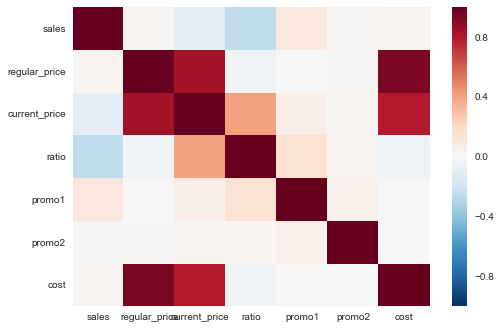

In [35]:
# plot the heatmap
sns.heatmap(corr_sales)
plt.show()

The two price variables (regular and current price) are heavily correlated which makes a lot of sense. Regular price is heavily correlated with cost which makes perfect sense and current price is also positively correlated with cost. Ratio looks to be moderately correlated with the current_price which again makes sense since it is the results of regular_price/current_price. Ratio looks to be moderately negatively correlated with sales which would imply that as teh ratio goes down, the sales go up; this intuitively makes sense since reduced prices hypothetically make for more purchases.

Lastly, it looks like promo1 is loosely correlated with sales; more so than promo2's correlation with sales.

At this point, it isn't very clear which promotion drives sales more. I would hazard a guess that promo1 does influence sales more based on the more positive correlation. As far as pricing goes, it looks like the like there is a moderate correlation between reducing the ratio (decreasing the current_price) and increasing sales.

I think the best approach would be to prepare the joined sales data for applying machine learning for a numerical output (not a classifer). It looks like some form of ordinary least squares regression, logistic regression, lasso regression, ARIMA, or random forest regression will be the best way to approach this problem.

### Machine Learning: Regression

Steps required for adequately performing machine learning on sales data using a Pipeline for evaluating many different combinations of features/algorithms and using proper validation technique(s) like cross-validation:

A. Feature creation (Ideas listed below for creating new variables to help with machine learning, re-run correlation matrix with the new features):
    - month (1 through 12)
    - season (1 through 4: winter, spring, summer, fall)
    - type of clothing (convert to a unique number for each article of clothing)
    - country number (convert country variable to a unique number)

B. Split data into features (data, ~ X) and target (sales ~ Y) for machine learning regressions. Take the features and targets and split into training and testing data as well so I can properly evaluate my results against 'new' data so I can better judge the performance.

C. Use a SKLearn Pipeline for steps 1 through 5
    1. Transform data (feature scaling, etc.)
    2. Dimensionality reduction (PCA)
    3. Feature selection (k-best, k-means, etc.)
    4. Machine learning algorithm selection (evaluate different combinations and machine learning algorithms while using cross-validation methods to ensure valid results)
    5. Evaluate results using the following metrics: accuracy, precision, recall

##### A. Feature Creation

Create week, month, and year variables in the joined dataframe using pandas datetime.

Create season variable based on the month: Winter (1), Spring (2), Summer (3), Fall (4).

In [36]:
# create date columns
data_joined['week'] = data_joined['retailweek'].dt.week
data_joined['month'] = data_joined['retailweek'].dt.month
data_joined['year'] = data_joined['retailweek'].dt.year

In [37]:
# create season column
data_joined['season'] = data_joined['retailweek'].apply(lambda dt: (dt.month%12 + 3)//3)

In [38]:
# verify columns were created correctly
data_joined.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost,week,month,year,season
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,RUNNING,T-SHIRTS,3.2,52,12,2014,1
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,RUNNING,T-SHIRTS,3.2,1,1,2015,1
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,RUNNING,T-SHIRTS,3.2,2,1,2015,1
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,RUNNING,T-SHIRTS,3.2,3,1,2015,1
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,RUNNING,T-SHIRTS,3.2,4,1,2015,1


Create unique identifier (numerical) for country, category of clothing, and product group of clothing.

In [39]:
# country
data_joined['country'] = pd.Categorical(data_joined['country'])
data_joined['country_code'] = data_joined.country.cat.codes

In [40]:
# clothing category
data_joined['category'] = pd.Categorical(data_joined['category'])
data_joined['category_code'] = data_joined.category.cat.codes

In [41]:
# product group of clothing
data_joined['productgroup'] = pd.Categorical(data_joined['productgroup'])
data_joined['productgroup_code'] = data_joined.productgroup.cat.codes

In [42]:
# verify columns were created correctly
data_joined.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost,week,month,year,season,country_code,category_code,productgroup_code
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,RUNNING,T-SHIRTS,3.2,52,12,2014,1,2,15,5
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,RUNNING,T-SHIRTS,3.2,1,1,2015,1,2,15,5
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,RUNNING,T-SHIRTS,3.2,2,1,2015,1,2,15,5
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,RUNNING,T-SHIRTS,3.2,3,1,2015,1,2,15,5
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,RUNNING,T-SHIRTS,3.2,4,1,2015,1,2,15,5


Verify that all of the feature creations have worked - get the summary data from the dataframe.

In [43]:
data_joined.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,cost,week,month,year,season,country_code,category_code,productgroup_code
count,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000
mean,57.107868,52.661044,28.377229,0.544421,0.065041,0.005067,5.002254,24.504065,5.943089,2015.707317,2.349593,1.139183,13.983359,2.104387
std,88.552281,35.561332,22.714819,0.192656,0.246599,0.071006,3.352216,15.592138,3.527615,0.718310,1.104202,0.908193,5.886354,1.459392
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,0.400000,1.000000,1.000000,2014.000000,1.000000,0.000000,0.000000,0.000000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,2.400000,11.000000,3.000000,2015.000000,1.000000,0.000000,8.000000,1.000000
50%,26.000000,41.950000,21.950000,0.523526,0.000000,0.000000,4.000000,23.000000,5.000000,2016.000000,2.000000,1.000000,15.000000,2.000000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000,7.700000,38.000000,9.000000,2016.000000,3.000000,2.000000,20.000000,3.000000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000,19.800000,53.000000,12.000000,2017.000000,4.000000,2.000000,20.000000,5.000000


Created features look good. I'll re-run the correlation matrix and heatmap to see if the new features turn up any noticeable correlations.

In [44]:
# calculate correlation matrix
corr_sales2 = data_joined.corr()
corr_sales2

,sales,regular_price,current_price,ratio,promo1,promo2,cost,week,month,year,season,country_code,category_code,productgroup_code
sales,1.000000,1.839857e-02,-0.102018,-0.257473,1.032704e-01,0.010210,2.733576e-02,1.097161e-01,1.150608e-01,-3.430681e-02,6.661149e-02,1.026768e-02,1.440983e-03,2.683328e-02
regular_price,0.018399,1.000000e+00,0.842917,-0.042704,2.757147e-18,0.010322,9.430526e-01,5.967095e-18,8.213789e-19,-5.070203e-16,1.515436e-17,-1.810102e-02,-1.922779e-01,-6.722818e-04
current_price,-0.102018,8.429173e-01,1.000000,0.408878,6.875311e-02,0.022557,7.916877e-01,-1.205519e-01,-1.369464e-01,1.455535e-02,-1.403676e-01,-1.848454e-02,-1.619012e-01,-5.316565e-04
ratio,-0.257473,-4.270398e-02,0.408878,1.000000,1.518774e-01,0.028358,-4.497662e-02,-2.682422e-01,-3.050156e-01,3.342310e-02,-3.119895e-01,-5.699931e-03,-1.073240e-02,-3.619556e-02
promo1,0.103270,2.757147e-18,0.068753,0.151877,1.000000e+00,0.053529,-2.981691e-18,2.714865e-01,2.263260e-01,-1.445897e-01,-8.350518e-02,-4.241454e-18,1.223813e-17,-5.326235e-17
promo2,0.010210,1.032208e-02,0.022557,0.028358,5.352861e-02,1.000000,-1.102974e-02,2.269971e-03,-5.448422e-02,4.240758e-03,-3.875337e-02,-1.093729e-02,1.656361e-02,-7.003895e-03
cost,0.027336,9.430526e-01,0.791688,-0.044977,-2.981691e-18,-0.011030,1.000000e+00,9.910704e-18,9.701922e-18,1.019659e-16,-7.585296e-18,7.171979e-03,-2.385169e-01,4.957921e-02
week,0.109716,5.967095e-18,-0.120552,-0.268242,2.714865e-01,0.002270,9.910704e-18,1.000000e+00,9.120859e-01,-2.866282e-01,5.573751e-01,5.296097e-18,-1.101337e-17,3.648673e-19
month,0.115061,8.213789e-19,-0.136946,-0.305016,2.263260e-01,-0.054484,9.701922e-18,9.120859e-01,1.000000e+00,-3.338445e-01,6.333641e-01,-1.696930e-17,1.013697e-17,2.975445e-18
year,-0.034307,-5.070203e-16,0.014555,0.033423,-1.445897e-01,0.004241,1.019659e-16,-2.866282e-01,-3.338445e-01,1.000000e+00,-2.195080e-01,-1.904598e-16,-2.334056e-16,7.512533e-17


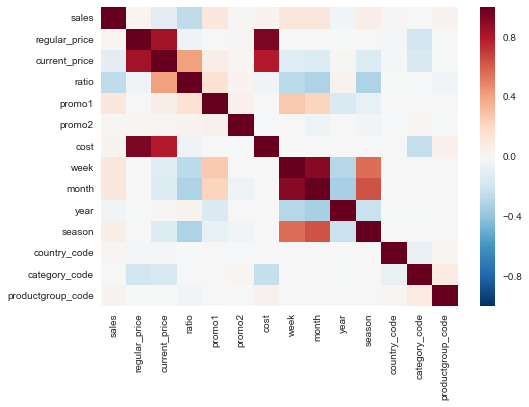

In [45]:
# plot the heatmap
sns.heatmap(corr_sales2)
plt.show()

Of the new features, the majority don't have any correlations that would be useful (or not intuitive). One that sticks out as possibly important is the category_code feature is negatively correlated with cost, regular_price, and current_price. A set of new correlations of note are the correlations between date (like week and month) and seasonality with ratio and promo1. These correlations could be useful in creating a robust machine learning algorithm for predicting future sales.

Create the features and target data along with splitting into training and testing data.

##### B. Create Feature and Target Data and Training/Testing Data Subsets

SKLearn machine learning functions receive lists and generally can handle numpy arrays so I'll split out the data into two lists: 1 for the target (Y) which is the sales column and 1 for the features (X) which are all of the other columns that are numerical.

In [46]:
# define features I want to use and what the target data is
features_list = ['regular_price', 'current_price', 'ratio', 'promo1', 'promo2', 'cost', \
'week', 'month', 'year', 'season', 'country_code', 'category_code', 'productgroup_code']
target_list = ['sales']

In [47]:
# subset joined dataframe into df_features and target
df_features = data_joined[features_list]
df_features.head()

,regular_price,current_price,ratio,promo1,promo2,cost,week,month,year,season,country_code,category_code,productgroup_code
0,31.95,25.95,0.812207,1,0,3.2,52,12,2014,1,2,15,5
1,31.95,22.95,0.718310,0,0,3.2,1,1,2015,1,2,15,5
2,31.95,28.95,0.906103,0,0,3.2,2,1,2015,1,2,15,5
3,31.95,29.95,0.937402,0,0,3.2,3,1,2015,1,2,15,5
4,31.95,24.95,0.780908,0,0,3.2,4,1,2015,1,2,15,5


In [48]:
df_features.shape

(81303, 13)

In [49]:
target = data_joined[target_list]
target.head()

,sales
0,62
1,29
2,58
3,49
4,883


In [50]:
target.shape

(81303, 1)

Subsetted dataframes look good, now split the data into train and testing splits. Generally, a 80%/20% or 70%/30% training/testing data split works so I'm going to start with 70/30 to maximize my testing data so I have the best possible idea of performance for new data since that is the goal of this case study.

In [51]:
features_train, features_test, target_train, target_test = train_test_split(df_features, target, \
                                                                            test_size=0.3, random_state=42)

Check sizing of created feature and target train/test splits

In [52]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(56912, 13) (24391, 13) (56912, 1) (24391, 1)


In [90]:
print(type(features_train), type(features_test), type(target_train), type(target_train))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


Training and testing data looks good. Next, I'll set up the SKLearn Pipeline for performing regressions.

##### C. Pipeline: Use a pipeline for finding and evaluating the best feature scaler, dimensionality reduction, feature selection, and machine learning algorithm

Create regressors, scalers, etc. for use in Pipeline

In [173]:
# regressions
LinReg = LinearRegression()
Las = Lasso() # optimize with GridSearchCV: alpha=[0.1, 0.3, 0.5, 0.7, 0.9, 1] (default=1)
DTree = DecisionTreeRegressor(random_state = 42) # min_samples_leaf (default=1), min_samples_split (default=2)
RF = RandomForestRegressor(random_state = 42)
# n_estimators (default=10), min_samples_leaf (default=1), min_samples_split (default=2)

# feature scaling
minMaxScaler = MinMaxScaler()
stdScaler = StandardScaler() #(could) optimize with: with_std=False

# dimensionality reduction and feature selection
PCAreducer = PCA(svd_solver='auto', random_state=42)
KBestSelector = SelectKBest(f_regression) # optimize: k = [3, 5, 7, 10, 13, 15] (default = 10)
KPercentSelector = SelectPercentile(f_regression) # optimize: percentile = [5, 10, 15, 20, 25] (default=10)

Create Pipeline including the machine learning tools I want to evaluate and the parameters I want to optimize for each of the tools used.

Use StratifiedShuffleSplit for cross-validation and GridSearchCV for parameter optimization within pipeline. I chose to optimize around r^2 since it encompasses a lot of quality of fit within 1 performance metric.

In [168]:
# convert features and target to numpy arrays
target_np = target.as_matrix(columns = target_list).ravel()
df_features_np = df_features.as_matrix(columns = features_list)
target_train_np = target_train.as_matrix(columns = target_list).ravel()
features_train_np = features_train.as_matrix(columns = target_list)

In [213]:
# create pipeline
pipe = Pipeline([
    ('scaler', stdScaler),
    ('PCA', PCAreducer),
    ('KBest', KBestSelector),
    ('reg', RF) # LinReg, Las, DTree, RF
])

# create parameters for GridSearchCV using pipeline
params = {
#     'PCA__n_components': [None, 13, 11, 9],
    'KBest__k': [9, 7, 5, 3],
    'reg__n_estimators': [3, 5, 8, 10, 15],
    'reg__min_samples_split': [2, 4, 6, 8, 10],
    'reg__min_samples_leaf': [1, 2, 4, 6, 8]
#     'reg__alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}
# scaler doesn't have any parameters to be used in this case
# linear regression algorithm doesn't have any params that need tuning

# create StratifiedShuffleSplit for cross-validation
# folds = 1000
# cvSetup = StratifiedShuffleSplit(target_np, folds, random_state=42)

# set up GridSearchCV
# gridSearch = GridSearchCV(pipe, param_grid = params, scoring = 'r2', \
#                          cv = cvSetup, verbose = 10)
gridSearch = GridSearchCV(pipe, param_grid = params, scoring = 'r2', verbose = 10) # scoring = 'r2',

# fit pipeline and grid search to training features and target dataset
gridSearch.fit(features_train, target_train_np)
# gridSearch.fit(df_features_np, target_np)

# store the best estimator (best classifier with parameters)
regr = gridSearch.best_estimator_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=3 
[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=3, score=-0.282333, total=   1.3s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=3, score=-0.306707, total=   1.6s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=3, score=-0.283300, total=   1.3s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=5, score=-0.156597, total=   2.0s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=5, score=-0.181608, total=   2.0s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=5, score=-0.162010, total=   2.0s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.5s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=8, score=-0.097044, total=   3.3s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.9s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=8, score=-0.104390, total=   3.7s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   17.7s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=8, score=-0.084369, total=   3.3s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=10 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   21.1s remaining:    0.0s


[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=10, score=-0.071676, total=   3.9s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=10 
[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=10, score=-0.078009, total=   4.4s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=10 
[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=10, score=-0.061859, total=   4.5s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=15 
[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=15, score=-0.038852, total=   7.6s
[CV] KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=15 
[CV]  KBest__k=9, reg__min_samples_leaf=1, reg__min_samples_split=2, reg__n_estimators=15, score=-0.049245, total=   6.0s
[CV] KBest__k=9, reg__min_samp

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 49.4min finished


In [214]:
# create handle
KBest_handle = gridSearch.best_estimator_.named_steps['KBest']

# Get SelectKBest scores rounded to 2 decimal places
feature_scores = ['%.2f' % elem for elem in KBest_handle.scores_]
# Get SelectKBest pvalues, rounded to 2 decimal places
feature_scores_pvalues = ['%.2f' % elem for elem in  KBest_handle.pvalues_]

# Create a tuple of SelectKBest feature names, scores and pvalues
features_selected_tuple=[(features_list[i], feature_scores[i], \
                          feature_scores_pvalues[i]) for i in KBest_handle.get_support(indices=True)]
# Sort by reverse score order
features_selected_tuple = sorted(features_selected_tuple, key=lambda feature: float(feature[1]) , reverse=True)

# Print selected feature names and scores
print(' ')
print('Selected Features, Scores, P-Values:')
print(features_selected_tuple)

# print best parameters and corresponding score from gridSearchCV
print(' ')
print('Best parameters:')
print(gridSearch.best_params_)
print('')
print('Best score:')
print(gridSearch.best_score_)

 
Selected Features, Scores, P-Values:
[('year', '2238.41', '0.00'), ('regular_price', '807.04', '0.00'), ('week', '737.38', '0.00'), ('current_price', '555.71', '0.00'), ('ratio', '239.88', '0.00'), ('cost', '237.39', '0.00'), ('season', '94.57', '0.00'), ('promo2', '62.03', '0.00'), ('month', '37.67', '0.00')]
 
Best parameters:
{'KBest__k': 9, 'reg__min_samples_leaf': 8, 'reg__min_samples_split': 2, 'reg__n_estimators': 15}

Best score:
0.0612509005923


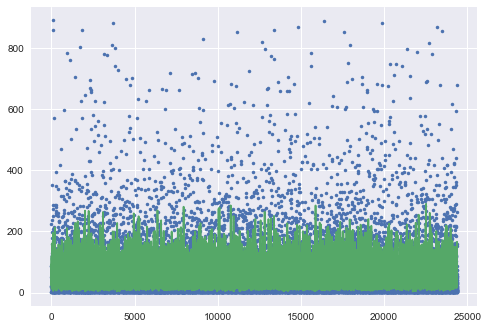

In [215]:
# make predictions based on test data split
pred = gridSearch.predict(features_test)

# plot predictions (regression) vs target (truth)
x = np.arange(len(pred))
plt.figure()
plt.plot(x, target_test, '.')
plt.plot(x, pred, '-')
plt.show()

In [216]:
# print results
print('mean_absolute_error:', mean_absolute_error(target_test, pred))
print('mean_squared_error:', mean_squared_error(target_test, pred))
print('median_absolute_error:', median_absolute_error(target_test, pred))
print('r2_score:', r2_score(target_test, pred))

mean_absolute_error: 49.4836828216
mean_squared_error: 7036.34696372
median_absolute_error: 31.2376815788
r2_score: 0.0647101068022


I have tested 4 different machine learning regressors so far: linear, lasso, decision tree, and random forest regressors. The linear, lasso, and random forest regressors resulted in a r^2 score of less than 0.1 which is really poor. The latest test from the decision tree regressor yielded a result of -0.297 which is roughly 3 times better than the other regressors. I am definitely limited in my optimial model search by a lack of computing power.

### Regression/Machine Learning Issues and Brainstorming
I have noticed the quality of the fits of the models have all be lacking. One huge reason for this is a lack of computing power so I can't exhaustively try to find the best model. Also, I do not have much experience with time series data for such a varied population (different articles of clothing types) and I think it is causing problems. I have a few ideas to try that might help with getting a better handle on this dataset. Below are some possible next steps:
1. Return to do some more data wrangling to decompose and remove seasonality from the data. Then move forward with machine learning or a different type of modeling like ARIMA which is supposed to be good for time series data and forecasting.
2. Introduce a better way to split the data - i.e. use SKLearn's TimeSeriesSplit function within model_selection to make better use of the fact that the data is time series and therefore time dependent.
3. Return to data wrangling and just look at 1 article of clothing to see how I can do with a smaller dataset. If this works, then move on to other pieces of clothing. Considering how the attribute data has 476 entries, I would need to iterate through 476 different articles of clothing - this method would be very time consuming to apply on a production scale.

## 5. Conclusions and What I Would Have Improved On If I Had More Time

### Improvements
1. Try more modeling / machine learning options like the ARIMA and SARIMA models used for time series regressions. These are often used in sales data and demand forecasting.

### Conclusions

FILL IN